## Reaktoro for modeling softening and acid addition pre-treatment for desalination systems


#### Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling
* cyipopt - Solver necessary for use with gray box models
* Reaktoro-pse - Python package for building Reaktoro gray box models
* watertap-solvers - for cyipopt solver wrapper

This example demonstrates how Reaktoro blocks can model pre-treatment and other chemistry phenomena in a water treatment train:

1) Precipitation processes - here modeled as Lime and Soda ash softening for Calcite precipitation. Reaktoro can be configured to use any number of chemicals and users can choose the set of solids to be formed from those available in selected databases.
2) Acidification or pH control - here we add HCl to control effluent pH. Any number of chemicals can be added to modify effluent properties
3) Scaling predictions in desalination, or concentration process - here we monitor formation of Calcite and Gypsum in a hypothetical water concentration process that perfectly removes water from the brine. 

The demo below uses simplified models, but all of these can be replaced with higher fidelity models available in WaterTAP and PrOMMiS

<img src="softening_acid_ro.png" width="1200" height="300">

### Demonstration structure 
1. Importing modules and setup pyomo model
2. Setting up feed
3. Creating simple softening model with Reaktoro
4. Creating simple acid addition model with Reaktoro
5. Adding Concentrator model, with scaling calculation using Reaktoro
6. Fix all variables, scale, and initialize units
7. Add costing objective and setup optimization
8. Run simple analysis against water recovery

## 1. Import needed modules and setup Pyomo/IDAES model

In [1]:
## Import core components
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Expression,
    Objective,
    ConcreteModel,
    Block,
    value,
    assert_optimal_termination,
    units as pyunits,
)

# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import (
    set_scaling_factor,
    constraint_scaling_transform,
)
from idaes.core.util.model_statistics import degrees_of_freedom

from pyomo.util.calc_var_value import calculate_variable_from_constraint

# Import reaktoro-pse and reaktoro
from reaktoro_pse.reaktoro_block import ReaktoroBlock
import reaktoro
from reaktoro_pse.core.util_classes.cyipopt_solver import (
    get_cyipopt_watertap_solver,
)

m = ConcreteModel()
# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)
# can use NaCl or Sea water prop pack

## 2. Setup the feed composition and block

Typical composition of sea water with ion concentration in mg/L and pH

In [2]:
sea_water_composition = {
    "Na": 10556,
    "K": 380,
    "Ca": 400,
    "Mg": 1262,
    "Cl": 18978,
    "SO4": 2649,
    "HCO3": 140,
}
ion_mw = {
    "Na": 22.989769 / 1000,
    "K": 39.0983 / 1000,
    "Ca": 40.078 / 1000,
    "Mg": 24.305 / 1000,
    "Cl": 35.453 / 1000,
    "SO4": 96.06 / 1000,
    "HCO3": 61.0168 / 1000,
    "H2O": 18.01528 / 1000,
}
# Get ions
ions = list(sea_water_composition.keys())
#

sea_water_ph = 7.56

##### 2.1 Simple feed block 

In [3]:
m.fs.feed = Block()
m.fs.feed.species_concentrations = Var(
    ions, initialize=1, bounds=(0, None), units=pyunits.mg / pyunits.L
)
# ReaktoroBlock needs mass flows of all the species
ions.append("H2O")
m.fs.feed.species_mass_flow = Var(
    ions, initialize=1, bounds=(0, None), units=pyunits.kg / pyunits.s
)

# ion mw
m.fs.feed.specie_mw = Param(ions, units=pyunits.kg / pyunits.mol)
# Create pH variable for feed
m.fs.feed.pH = Var(initialize=sea_water_ph)
m.fs.feed.pH.fix()

# Create temperature variable for feed
m.fs.feed.temperature = Var(initialize=293, units=pyunits.K)
m.fs.feed.temperature.fix()

# Create pressure variable for feed
m.fs.feed.pressure = Var(initialize=1e5, units=pyunits.Pa)
m.fs.feed.pressure.fix()

# To get true flow mass, the density is needed for the solution, we can get that from reaktoro
m.fs.feed.density = Var(initialize=1053, units=pyunits.kg / pyunits.m**3)
m.fs.feed.density.fix()


# Write constraints to convert concentration to mass flows
@m.fs.feed.Constraint(list(m.fs.feed.species_mass_flow.keys()))
def eq_feed_species_mass_flow(fs, ion):
    if ion == "H2O":
        return Constraint.Skip
    else:
        """calculate mass flow based on density"""
        return m.fs.feed.species_mass_flow[ion] == pyunits.convert(
            m.fs.feed.species_concentrations[ion]
            * m.fs.feed.species_mass_flow["H2O"]
            / m.fs.feed.density,
            to_units=pyunits.kg / pyunits.s,
        )

## 3. Creating simple softening model with Reaktoro

We assume a softening process that uses lime and soda ash to remove calcite.
We balance apparent species only in our IDAES/WaterTAP model as follows:

$$ CaO \rightarrow Ca + H2O $$

$$ Na2CO3 \rightarrow 2Na + HCO3 $$

and for Calcite

$$ Ca + HCO3 \rightarrow CaCO3 (Calcite) $$

Lets start by creating a process block, and adding our chemical reagents and solids forming variables, as well as mass balance constraints. 

The created regent variables, as well as, formed solids variables will be used as inputs and outputs in the Reaktoro model. 

In [4]:
m.fs.softening = Block()
m.fs.softening.reagents_mol_flow = Var(
    ["CaO", "Na2CO3"],
    initialize=1e-7,
    bounds=(1e-10, None),
    units=pyunits.mol / pyunits.s,
)

m.fs.softening.reagent_dose = Var(
    ["CaO", "Na2CO3"], initialize=1e-7, units=pyunits.mg / pyunits.kg
)
m.fs.softening.reagents_mw = Param(["CaO", "Na2CO3"], units=pyunits.kg / pyunits.mol)
m.fs.softening.reagents_mw["CaO"] = 56.0774 / 1000
m.fs.softening.reagents_mw["Na2CO3"] = 105.99 / 1000

m.fs.softening.precipitants = Var(["Calcite"], initialize=1e-32, units=pyunits.mol)
m.fs.softening.precipitants_mw = Param(
    ["Calcite"], initialize=100.09 / 1000, units=pyunits.kg / pyunits.mol
)

m.fs.softening.effluent_pH = Var(
    initialize=7, bounds=(5, 12), units=pyunits.dimensionless
)
m.fs.softening.effluent_alkalinity = Var(
    initialize=100, units=pyunits.mg / pyunits.L, bounds=(30, None)
)

##### 3.1 Mass balance constraints for softening process

For each ion where reagent and solid is participating 

$$ \dot{m}_{ion,out}= \dot{m}_{ion,in} + \dot{m}_{ion,reagent} -\dot{m}_{ion,solid} $$

Example for Calcium:
$$ \dot{m}_{Ca,out}= \dot{m}_{Ca,in} + \dot{m}_{Ca,CaO} -\dot{m}_{Ca,Calcite} $$

Otherwise:

$$ \dot{m}_{ion,out}= \dot{m}_{ion,in} $$

In [5]:
m.fs.softening.effluent_species_mass_flows = Var(
    ions, initialize=1e-5, units=pyunits.kg / pyunits.s
)


@m.fs.softening.Constraint(ions)
def eq_effluent_species_mass_flows(fs, ion):
    if "Ca" == ion:
        return m.fs.softening.effluent_species_mass_flows["Ca"] == (
            m.fs.softening.reagents_mol_flow["CaO"] * m.fs.feed.specie_mw["Ca"]
            + m.fs.feed.species_mass_flow["Ca"]
            - m.fs.softening.precipitants["Calcite"] * m.fs.feed.specie_mw["Ca"]
        )
    elif "Na" == ion:
        return m.fs.softening.effluent_species_mass_flows["Na"] == (
            2 * m.fs.softening.reagents_mol_flow["Na2CO3"] * m.fs.feed.specie_mw["Na"]
            + m.fs.feed.species_mass_flow["Na"]
        )
    elif "HCO3" == ion:
        return m.fs.softening.effluent_species_mass_flows["HCO3"] == (
            m.fs.feed.species_mass_flow["HCO3"]
            + m.fs.softening.reagents_mol_flow["Na2CO3"] * m.fs.feed.specie_mw["HCO3"]
            - m.fs.softening.precipitants["Calcite"] * m.fs.feed.specie_mw["HCO3"]
        )
    else:
        return (
            m.fs.softening.effluent_species_mass_flows[ion]
            == m.fs.feed.species_mass_flow[ion]
        )


@m.fs.softening.Constraint(["CaO", "Na2CO3"])
def eq_dose(fs, reagent):
    return m.fs.softening.reagent_dose[reagent] == pyunits.convert(
        m.fs.softening.reagents_mol_flow[reagent]
        * m.fs.softening.reagents_mw[reagent]
        / m.fs.feed.species_mass_flow["H2O"],
        to_units=pyunits.mg / pyunits.kg,
    )

##### 3.2 Softening Reaktoro outputs

In [6]:
"""We need to define an output dictionary with our properties - this can also be an Pyomo IndexedVar.
Please check examples in examples folder for how to use IndexedVars as outputs"""

m.fs.softening.reaktoro_outputs = {
    (
        "speciesAmount",
        "Calcite",
    ): m.fs.softening.precipitants["Calcite"],
    ("alkalinityAsCaCO3", None): m.fs.softening.effluent_alkalinity,
    ("pH", None): m.fs.softening.effluent_pH,
}

##### 3.3 Configure ReaktoroBlock
We are dealing with seawater desalination, which implies operation at high salinity and pressure. For such conditions the Pitzer database from PhreeqC is a good choice.
For comparison of PhreeqC databases, the following paper is a good reference: https://doi.org/10.1016/j.earscirev.2021.103888 

In [7]:
m.fs.softening.eq_precipitation = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.feed.species_mass_flow,  # This is the species mass flow
        "convert_to_rkt_species": True,  # We can use default converter as its defined for default database (Phreeqc and pitzer)
        "activity_model": reaktoro.ActivityModelPitzer(),  # Can provide a string, or Reaktoro initialized class
        "fixed_solvent_specie": "H2O",  # We need to define our aqueous solvent as we have to speciate the block
    },
    system_state={
        "temperature": m.fs.feed.temperature,
        "pressure": m.fs.feed.pressure,
        "pH": m.fs.feed.pH,
    },
    mineral_phase={"phase_components": ["Calcite"]},
    chemistry_modifier={
        "CaO": m.fs.softening.reagents_mol_flow["CaO"],
        "Na2CO3": m.fs.softening.reagents_mol_flow["Na2CO3"],
    },
    outputs=m.fs.softening.reaktoro_outputs,  # This is the output dictionary we defined above
    database_file="pitzer.dat",  # needs to be a string that names the database file or points to its location
    build_speciation_block=True,  # We provided apparent species so we need to speciate them.
)

2026-01-27 10:49:07 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2026-01-27 10:49:07 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2026-01-27 10:49:07 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[H]', '[O]', '[H+]']
2026-01-27 10:49:07 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'H_dummy_constraint', 'O_dummy_constraint', 'pH']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

## 4. Creating simple acid addition model with Reaktoro
We are adding HCl here, so assume that it dissociate in to Cl, ignoring H as we are only tracking measurable apparent species, addition of "H" will be tracked through pH by Reaktoro output. 

 $$HCl \rightarrow Cl$$

In [8]:
m.fs.acid_addition = Block()
m.fs.acid_addition.reagents_mol_flow = Var(
    ["HCl"], initialize=1e-5, bounds=(1e-10, None), units=pyunits.mol / pyunits.s
)
m.fs.acid_addition.reagent_dose = Var(
    ["HCl"], initialize=1, units=pyunits.mg / pyunits.kg
)
m.fs.acid_addition.reagents_mw = Param(
    ["HCl"], initialize=136.46 / 1000, units=pyunits.kg / pyunits.mol
)
m.fs.acid_addition.effluent_species_mass_flows = Var(
    ions, initialize=1e-5, units=pyunits.kg / pyunits.s
)
m.fs.acid_addition.effluent_pH = Var(
    initialize=7, bounds=(5, 12), units=pyunits.dimensionless
)


@m.fs.acid_addition.Constraint(ions)
def eq_effluent_species_mass_flows(fs, ion):
    if "Cl" == ion:
        return m.fs.acid_addition.effluent_species_mass_flows["Cl"] == (
            m.fs.acid_addition.reagents_mol_flow["HCl"] * m.fs.feed.specie_mw["Cl"]
            + m.fs.softening.effluent_species_mass_flows["Cl"]
        )
    else:
        return (
            m.fs.acid_addition.effluent_species_mass_flows[ion]
            == m.fs.softening.effluent_species_mass_flows[ion]
        )


@m.fs.acid_addition.Constraint(["HCl"])
def eq_dose(fs, reagent):
    return m.fs.acid_addition.reagent_dose[reagent] == pyunits.convert(
        m.fs.acid_addition.reagents_mol_flow[reagent]
        * m.fs.acid_addition.reagents_mw[reagent]
        / m.fs.feed.species_mass_flow["H2O"],
        to_units=pyunits.mg / pyunits.kg,
    )

##### 4.1 Configure acid addition Reaktoro block

In [9]:
m.fs.acid_addition.reaktoro_outputs = {("pH", None): m.fs.acid_addition.effluent_pH}

m.fs.acid_addition.eq_acid_addition = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.softening.effluent_species_mass_flows,  # This is the speciesmass flow
        "convert_to_rkt_species": True,  # We can use default converter as its defined for default database (Phreeqc and pitzer)
        "activity_model": reaktoro.ActivityModelPitzer(),  # Can provide a string, or Reaktoro initialized class
        "fixed_solvent_specie": "H2O",  # We need to define our aqueous solvent as we have to speciate the block
    },
    system_state={
        "temperature": m.fs.feed.temperature,
        "pressure": m.fs.feed.pressure,
        "pH": m.fs.softening.effluent_pH,
    },
    chemistry_modifier={"HCl": m.fs.acid_addition.reagents_mol_flow["HCl"]},
    outputs=m.fs.acid_addition.reaktoro_outputs,  # This is the output dictionary we defined above
    database_file="pitzer.dat",  # needs to be a string that names the database file or points to its location
    build_speciation_block=True,  # We provided apparent species so we need to speciate them.
)

2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[H]', '[O]', '[H+]']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'H_dummy_constraint', 'O_dummy_constraint', 'pH']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

### 5. Adding Concentrator model, with scaling calculation using Reaktoro

Lets add a simple concentrator to mimic operation of RO/MVC/ or other concentration process where we simply remove water from the feed.  

In [10]:
m.fs.desalter = Block()
m.fs.desalter.water_recovery = Var(
    initialize=0.1, bounds=(0, 0.99), units=pyunits.dimensionless
)
m.fs.desalter.water_removed = Var(initialize=0, units=pyunits.mol / pyunits.s)
m.fs.desalter.scaling_tendency = Var(
    ["Calcite", "Gypsum"], initialize=1, bounds=(None, 1), units=pyunits.dimensionless
)

m.fs.desalter.eq_water_removal = Constraint(
    expr=(m.fs.desalter.water_removed * m.fs.feed.specie_mw["H2O"])
    / m.fs.acid_addition.effluent_species_mass_flows["H2O"]
    == m.fs.desalter.water_recovery
)

m.fs.desalter.effluent_pH = Var(
    initialize=7, bounds=(5, 12), units=pyunits.dimensionless
)

##### 5.1 Reaktoro block for scaling potential monitoring

In [11]:
m.fs.desalter.reaktoro_outputs = {
    ("scalingTendency", "Calcite"): m.fs.desalter.scaling_tendency["Calcite"],
    ("scalingTendency", "Gypsum"): m.fs.desalter.scaling_tendency["Gypsum"],
    ("pH", None): m.fs.desalter.effluent_pH,
}

m.fs.desalter.eq_scaling_potential = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.acid_addition.effluent_species_mass_flows,  # This is the speciesmass flow
        "convert_to_rkt_species": True,  # We can use default converter as its defined for default database (Phreeqc and pitzer)
        "activity_model": reaktoro.ActivityModelPitzer(),  # Can provide a string, or Reaktoro initialized class
        "fixed_solvent_specie": "H2O",  # We need to define our aqueous solvent as we have to speciate the block
    },
    system_state={
        "temperature": m.fs.feed.temperature,
        "pressure": m.fs.feed.pressure,
        "pH": m.fs.acid_addition.effluent_pH,
    },
    chemistry_modifier={"H2O_evaporation": m.fs.desalter.water_removed},
    outputs=m.fs.desalter.reaktoro_outputs,  # This is the output dictionary we defined above
    database_file="pitzer.dat",  # needs to be a string that names the database file or points to its location
    build_speciation_block=True,  # We provided apparent species so we need to speciate them.
)

2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[O]', '[H]', '[H+]']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'O_dummy_constraint', 'H_dummy_constraint', 'pH']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

### 6. Fix, scale, and initialize all units

##### 6.1 Feed

In [12]:
m.fs.feed.species_mass_flow["H2O"].fix(1.0)  # Fixing water flow to 1 kg/s

# fix concentrations
for ion, val in sea_water_composition.items():
    m.fs.feed.species_concentrations[ion].fix(val)
    m.fs.feed.specie_mw[ion] = ion_mw[ion]
    set_scaling_factor(m.fs.feed.species_concentrations[ion], 1 / val)
m.fs.feed.specie_mw["H2O"] = ion_mw["H2O"]
for comp, pyoobj in m.fs.feed.eq_feed_species_mass_flow.items():
    calculate_variable_from_constraint(m.fs.feed.species_mass_flow[comp], pyoobj)
    set_scaling_factor(
        m.fs.feed.species_mass_flow[ion], 1 / m.fs.feed.species_mass_flow[comp].value
    )
    constraint_scaling_transform(pyoobj, 1 / m.fs.feed.species_mass_flow[comp].value)
set_scaling_factor(m.fs.feed.density, 1 / 1000)
set_scaling_factor(m.fs.feed.pH, 1)
set_scaling_factor(m.fs.feed.temperature, 1 / 273)
set_scaling_factor(m.fs.feed.pressure, 1e-5)

##### 6.2 Softening unit

In [13]:
m.fs.softening.reagents_mol_flow["CaO"].fix(1e-5)
m.fs.softening.reagents_mol_flow["Na2CO3"].fix(1e-5)


for comp, pyoobj in m.fs.softening.eq_effluent_species_mass_flows.items():
    calculate_variable_from_constraint(
        m.fs.softening.effluent_species_mass_flows[comp], pyoobj
    )
    # Scale based on feed
    set_scaling_factor(
        m.fs.softening.effluent_species_mass_flows[ion],
        1 / m.fs.feed.species_mass_flow[comp].value,
    )
    constraint_scaling_transform(pyoobj, 1 / m.fs.feed.species_mass_flow[comp].value)

for reagent in m.fs.softening.reagents_mol_flow.keys():
    set_scaling_factor(m.fs.softening.reagents_mol_flow[reagent], 1e4)
    set_scaling_factor(m.fs.softening.reagent_dose[reagent], 1)
    constraint_scaling_transform(m.fs.softening.eq_dose[reagent], 1)
for reagent in m.fs.softening.precipitants.keys():
    set_scaling_factor(m.fs.softening.precipitants[reagent], 1e4)
set_scaling_factor(m.fs.softening.effluent_pH, 1)

##### 6.3 Softening Reaktoro block

In [14]:
m.fs.softening.eq_precipitation.initialize()

for key, obj in m.fs.softening.reaktoro_outputs.items():
    print(key, value(obj))

# recompute effluent composition using updated amount of formed calcite.
for comp, pyoobj in m.fs.softening.eq_effluent_species_mass_flows.items():
    calculate_variable_from_constraint(
        m.fs.softening.effluent_species_mass_flows[comp], pyoobj
    )

2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.softening.eq_precipitation----
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
('speciesAmount', 'Calcite') 1.568743050168031e-05
('alkalinityAsCaCO3', None) 208.27025645638577
('pH', None) 7.612137236894974


##### 6.4 Acid addition unit

In [15]:
m.fs.acid_addition.reagents_mol_flow["HCl"].fix(1e-5)

for comp, pyoobj in m.fs.acid_addition.eq_effluent_species_mass_flows.items():
    calculate_variable_from_constraint(
        m.fs.acid_addition.effluent_species_mass_flows[comp], pyoobj
    )
    # Scale based on feed
    set_scaling_factor(
        m.fs.acid_addition.effluent_species_mass_flows[ion],
        1 / m.fs.feed.species_mass_flow[comp].value,
    )
    constraint_scaling_transform(pyoobj, 1 / m.fs.feed.species_mass_flow[comp].value)
set_scaling_factor(m.fs.acid_addition.effluent_pH, 1)

for reagent in m.fs.acid_addition.reagents_mol_flow.keys():
    set_scaling_factor(m.fs.acid_addition.reagents_mol_flow[reagent], 1e4)
    set_scaling_factor(m.fs.acid_addition.reagent_dose[reagent], 1)
    constraint_scaling_transform(m.fs.acid_addition.eq_dose[reagent], 1)

##### 6.5 Acid addition Reaktoro block

In [16]:
m.fs.acid_addition.eq_acid_addition.initialize()

for key, obj in m.fs.acid_addition.reaktoro_outputs.items():
    print(key, value(obj))

2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.acid_addition.eq_acid_addition----
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
('pH', None) 7.575189062277047


##### 6.6 Desalination/Concentration process

In [17]:
m.fs.desalter.water_recovery.fix(0.5)
# Do not apply limits to scaling, to ensure we can do a box solve as system might be in scaling regime!
m.fs.desalter.scaling_tendency["Calcite"].setub(None)
m.fs.desalter.scaling_tendency["Gypsum"].setub(None)
set_scaling_factor(m.fs.desalter.scaling_tendency["Calcite"], 1)
set_scaling_factor(m.fs.desalter.scaling_tendency["Gypsum"], 1)
calculate_variable_from_constraint(
    m.fs.desalter.water_removed, m.fs.desalter.eq_water_removal
)
set_scaling_factor(m.fs.desalter.water_removed, 1 / m.fs.desalter.water_removed.value)
constraint_scaling_transform(
    m.fs.desalter.eq_water_removal, 1 / m.fs.desalter.water_removed.value
)

##### 6.7 Scaling prediction Reaktoro block

In [18]:
m.fs.desalter.eq_scaling_potential.initialize()

for key, obj in m.fs.desalter.reaktoro_outputs.items():
    print(key, value(obj))

2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.desalter.eq_scaling_potential----
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:08 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-27 10:49:09 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
('scalingTendency', 'Calcite') 2.2027784337976746
('scalingTendency', 'Gypsum') 0.39895132565713765
('pH', None) 7.45144053957531


##### 6.8 Lets check DOFS, and run box solve to complete initializing  

In [19]:
print(degrees_of_freedom(m))
assert degrees_of_freedom(m) == 0
solver = get_cyipopt_watertap_solver(max_iter=200, linear_solver="mumps", pivtol=1e-4)

result = solver.solve(m, tee=True)
assert_optimal_termination(result)

0
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling

List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-09                 yes
                 acceptable_dual_inf_tol = 0.01                  yes
                          acceptable_tol = 1e-09                 yes
                      bound_relax_factor = 0                     yes
                         constr_viol_tol = 1e-08                 yes
                  diverging_iterates_tol = 1e+30                 yes
                            dual_inf_tol = 0.1                   yes
                   honor_original_bounds = no                    yes
                           linear_solver = mumps                 yes
                                max_iter = 200                   yes
                            mumps_pivtol = 0.0001                yes
                      nlp_scaling_method = user-sca

### 7. Add costing objective and setup optimizations

1. HCl cost = 0.1 $/kg
2. CaO cost = 0.25 $/kg
3. N2CO3 cost = 0.4 $/kg
4. Constrain process to maintain Scaling Tendency to be less then 1

Model will optimize the dosing of the 3 chemicals to minimize their cost, while ensuring no scaling occurs.

In [20]:
m.fs.chemical_costs = Param(
    ["HCl", "CaO", "Na2CO3"], initialize=1, units=pyunits.dimensionless
)
m.fs.chemical_costs["HCl"].set_value(0.1)
m.fs.chemical_costs["CaO"].set_value(0.25)
m.fs.chemical_costs["Na2CO3"].set_value(0.4)

m.fs.normalized_chemical_costs = Expression(
    expr=(
        m.fs.chemical_costs["CaO"]
        * m.fs.softening.reagents_mol_flow["CaO"]
        * m.fs.softening.reagents_mw["CaO"]
        + m.fs.chemical_costs["Na2CO3"]
        * m.fs.softening.reagents_mol_flow["Na2CO3"]
        * m.fs.softening.reagents_mw["Na2CO3"]
        + m.fs.chemical_costs["HCl"]
        * m.fs.acid_addition.reagents_mol_flow["HCl"]
        * m.fs.acid_addition.reagents_mw["HCl"]
    )
    / (m.fs.desalter.water_removed * m.fs.feed.specie_mw["H2O"] / m.fs.feed.density)
)  # $/m3

m.fs.cost_objective = Objective(expr=m.fs.normalized_chemical_costs)


m.fs.desalter.scaling_tendency["Calcite"].setub(1)
m.fs.desalter.scaling_tendency["Gypsum"].setub(1)

##### 7.1 Unfix chemical mol flows, so they can be optimized to satisfy our scaling constraints and minimize cost

In [21]:
# Unfix chemicals
m.fs.softening.reagents_mol_flow["CaO"].unfix()
m.fs.softening.reagents_mol_flow["Na2CO3"].unfix()
m.fs.acid_addition.reagents_mol_flow["HCl"].unfix()

## 8. Run simple analysis against water recovery

Configure runs over different water recoveries. 

This can take a while as each solve takes 10-15 seconds. In full implementations, we can use ReaktoroBlockManager to run Reaktoro block solvers in parallel to reduce computational time.

In [22]:
step = 5

# store data
output_data = {
    "water_recovery": [],
    "cost": [],
    "scaling_tendency_calcite": [],
    "scaling_tendency_gypsum": [],
    "dose_CaO": [],
    "dose_Na2CO3": [],
    "dose_HCl": [],
    "calcium_removal": [],
    "carbonate_removal": [],
    "softening_ph": [],
    "desalination_ph": [],
    "acid_ph": [],
    "softening_alkalinity": [],
}

for wr in range(50, 85 + step, step):
    m.fs.desalter.water_recovery.fix(wr / 100)
    print(f"Solving for water recovery {wr}%")
    result = solver.solve(m, tee=False)
    try:
        assert_optimal_termination(result)
    except:
        # Some times we fail to solve, so try again!
        result = solver.solve(m, tee=False)
        assert_optimal_termination(result)

    output_data["water_recovery"].append(m.fs.desalter.water_recovery.value * 100)
    output_data["cost"].append(value(m.fs.normalized_chemical_costs))
    output_data["scaling_tendency_calcite"].append(
        m.fs.desalter.scaling_tendency["Calcite"].value
    )
    output_data["scaling_tendency_gypsum"].append(
        m.fs.desalter.scaling_tendency["Gypsum"].value
    )
    output_data["dose_CaO"].append(m.fs.softening.reagent_dose["CaO"].value)
    output_data["dose_Na2CO3"].append(m.fs.softening.reagent_dose["Na2CO3"].value)
    output_data["dose_HCl"].append(m.fs.acid_addition.reagent_dose["HCl"].value)
    output_data["softening_ph"].append(m.fs.softening.effluent_pH.value)
    output_data["acid_ph"].append(m.fs.acid_addition.effluent_pH.value)
    output_data["desalination_ph"].append(m.fs.desalter.effluent_pH.value)
    output_data["softening_alkalinity"].append(m.fs.softening.effluent_alkalinity.value)
    output_data["calcium_removal"].append(
        100
        * (
            1
            - m.fs.softening.effluent_species_mass_flows["Ca"].value
            / (
                m.fs.feed.species_mass_flow["Ca"].value
                + m.fs.softening.reagents_mol_flow["CaO"].value
                * m.fs.softening.reagents_mw["CaO"].value
            )
        )
    )
    output_data["carbonate_removal"].append(
        100
        * (
            (
                m.fs.feed.species_mass_flow["HCO3"].value
                - m.fs.softening.effluent_species_mass_flows["HCO3"].value
            )
            / m.fs.feed.species_mass_flow["HCO3"].value
        )
    )

Solving for water recovery 50%
Solving for water recovery 55%
Solving for water recovery 60%
Solving for water recovery 65%
Solving for water recovery 70%
Solving for water recovery 75%
Solving for water recovery 80%
Solving for water recovery 85%


##### 8.1 Lets visualize it.  

Compare this to our work that used surrogates [with Soda ash and CO2 as pre-treament for RO](https://pubs.acs.org/doi/10.1021/acsestengg.3c00537) and [assessing value of different acids](https://psecommunity.org/LAPSE:2024.1535)

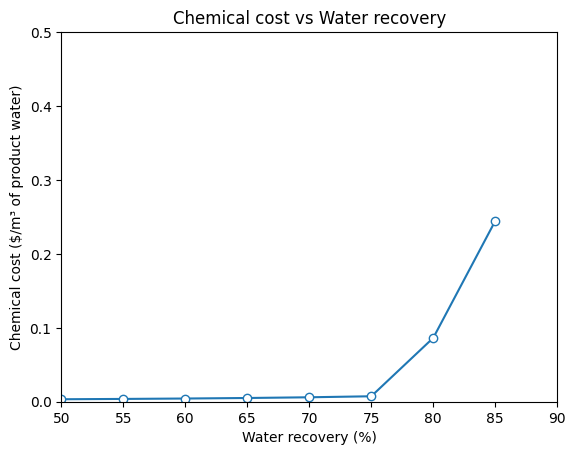

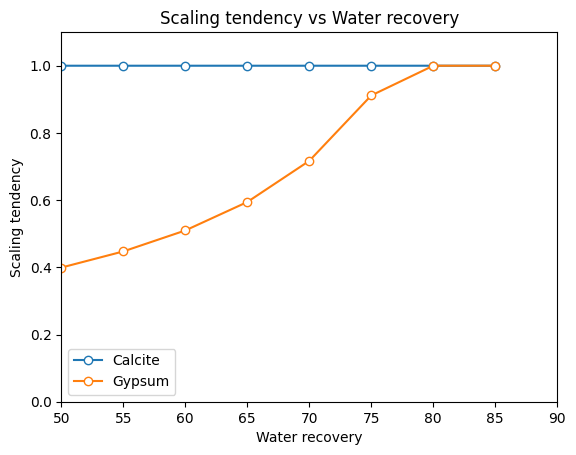

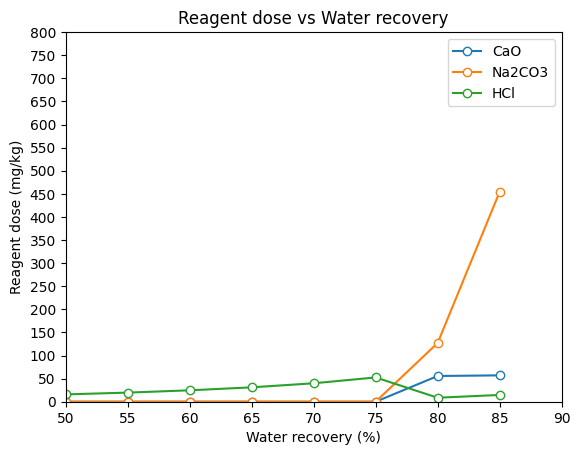

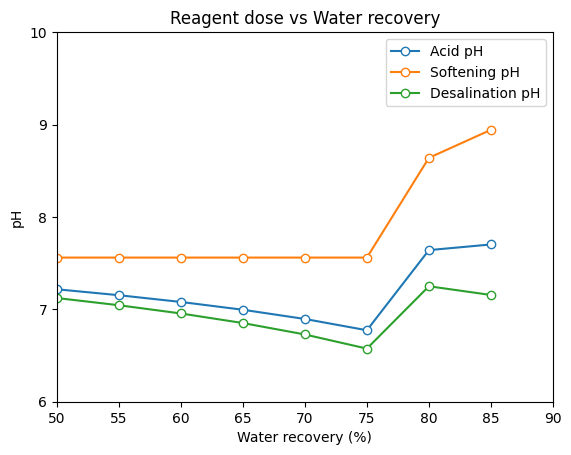

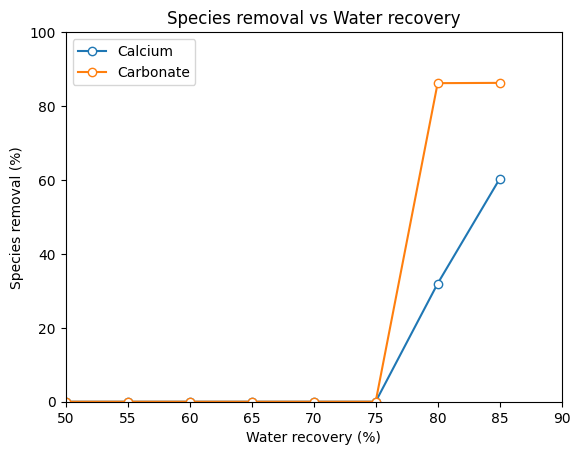

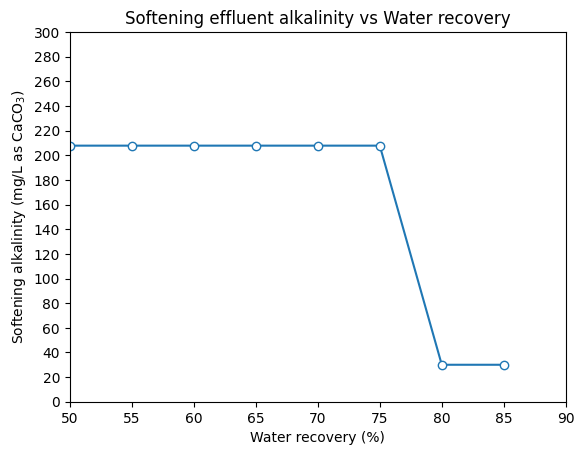

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(
    output_data["water_recovery"],
    output_data["cost"],
    marker="o",
    markerfacecolor="white",
)
ax.set_xlabel("Water recovery (%)")
ax.set_ylabel("Chemical cost ($/m³ of product water)")
ax.set_title(f"Chemical cost vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(0, 0.5)
plt.show()

fig, ax = plt.subplots()
for scale in ["Calcite", "Gypsum"]:
    ax.plot(
        output_data["water_recovery"],
        output_data[f"scaling_tendency_{scale.lower()}"],
        label=scale,
        marker="o",
        markerfacecolor="white",
    )
ax.set_xlabel("Water recovery")
ax.set_ylabel("Scaling tendency")
ax.set_title(f"Scaling tendency vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(0, 1.1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend()
plt.show()

fig, ax = plt.subplots()
for scale in ["CaO", "Na2CO3", "HCl"]:
    ax.plot(
        output_data["water_recovery"],
        output_data[f"dose_{scale}"],
        label=scale,
        marker="o",
        markerfacecolor="white",
    )
ax.set_xlabel("Water recovery (%)")
ax.set_ylabel("Reagent dose (mg/kg)")
ax.set_title(f"Reagent dose vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(0, 800)
ax.set_yticks(range(0, 850, 50))
ax.legend()
plt.show()

fig, ax = plt.subplots()
for scale in ["acid_ph", "softening_ph", "desalination_ph"]:
    ax.plot(
        output_data["water_recovery"],
        output_data[scale],
        label=f"{scale.replace('_ph', ' ').title()}pH",
        marker="o",
        markerfacecolor="white",
    )
ax.set_xlabel("Water recovery (%)")
ax.set_ylabel("pH")
ax.set_title(f"Reagent dose vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(6, 10)
ax.set_yticks([6, 7, 8, 9, 10])
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(
    output_data["water_recovery"],
    output_data["calcium_removal"],
    label="Calcium",
    marker="o",
    markerfacecolor="white",
)
ax.plot(
    output_data["water_recovery"],
    output_data["carbonate_removal"],
    label="Carbonate",
    marker="o",
    markerfacecolor="white",
)
ax.set_xlabel("Water recovery (%)")
ax.set_ylabel("Species removal (%)")
ax.set_title(f"Species removal vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 120, 20))
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(
    output_data["water_recovery"],
    output_data["softening_alkalinity"],
    marker="o",
    markerfacecolor="white",
)
ax.set_xlabel("Water recovery (%)")
ax.set_ylabel("Softening alkalinity (mg/L as CaCO$_3$)")
ax.set_title(f"Softening effluent alkalinity vs Water recovery")
ax.set_xticks(range(50, 91, 5))
ax.set_xlim(50, 90)
ax.set_ylim(0, 300)
ax.set_yticks(range(0, 320, 20))
plt.show()

In [24]:
output_data["cost"],

([np.float64(0.0033373357579250715),
  np.float64(0.003780496197500955),
  np.float64(0.004331394115253426),
  np.float64(0.005043881321300034),
  np.float64(0.006007109222623719),
  np.float64(0.007378365200560667),
  np.float64(0.08639433581929179),
  np.float64(0.24463776107072618)],)